### What is risk management?
Risk management is the identification, assessment, and prioritization of risks
followed by coordinated and economical application of resources to minimize,
monitor, and control the probability and/or impact of unfortunate events or to
maximize the realization of opportunities.

*Hubbard, Douglas (2009). The Failure of Risk Management: Why It's Broken and
How to Fix It. John Wiley & Sons.*

- Known risks: to identify and make them easy to understand
- Unknown risks

#### Coherence of a risk metric:
- Monotonicity
- Subadditivity
- Positive Homogeneity
- Translational Invariance


#### Market risk
The risk of loss for a UCITS or AIF resulting from fluctuation in the market value of positions in the fund's portfolio attributable to changes in market variables, such as interest rates, foreign exchange rates, equity and commodity prices or an issuer's credit worthiness (*by FCA*).

##### VaR
what is the maximum expected loss over a specified horizon given a specified level of signififcance; e.g. 20-day VaR 10% with 99% confidence interval

##### Historical VaR

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
spx = yf.download('^GSPC', start='1970-01-01', end='2020-11-30', progress=False)['Adj Close']
spx_ret = spx.pct_change().dropna()

In [3]:
historical_var = -np.percentile(spx_ret, 0.01)
historical_var

0.11281536413192207

In [4]:
(lambda r, level:-np.percentile(r, level))(spx_ret['2020'], 1)

0.07103226239857728

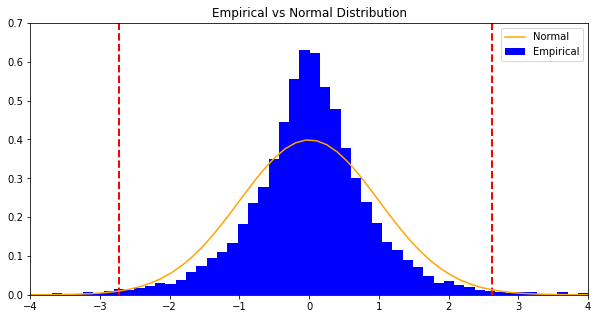

In [5]:
scalled_ret = (spx_ret - spx_ret.mean())/spx_ret.std()

# Define bins
x = np.linspace(scalled_ret.min(), scalled_ret.max(), 200)

# Calculate normal probability density function
y = (1/np.sqrt(2*np.pi)*np.exp(-0.5*x**2))

# Plot histogram of scaled returns
plt.figure(figsize=(10,5))
plt.hist(scalled_ret, bins=200, density=True, color = 'blue', label = 'Empirical', alpha=1)
plt.axvline(np.percentile(scalled_ret,1), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(scalled_ret,99), color='r', linestyle='dashed', linewidth=2)

# Plot norm pdf
plt.plot(x, y, color = 'orange', label = 'Normal')

# Set x and y axis limits
plt.xlim(-4,4)
plt.ylim(0,0.7)

plt.title('Empirical vs Normal Distribution')
plt.legend();

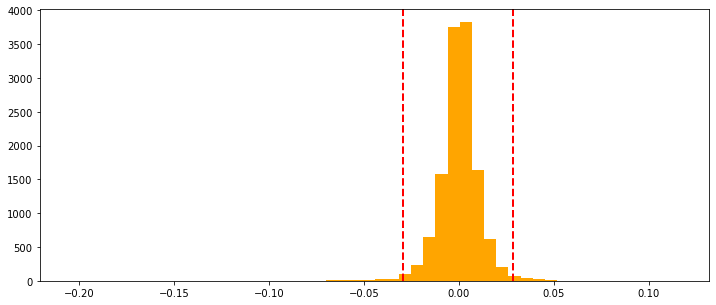

In [6]:
fig = plt.figure(figsize=(12,5))
plt.hist(spx_ret, bins=50, histtype='stepfilled', color='orange', alpha=1);
plt.axvline(np.percentile(spx_ret,1), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(spx_ret,99), color='r', linestyle='dashed', linewidth=2)

In [7]:
import scipy.stats
statistic, pvalue = scipy.stats.jarque_bera(spx_ret)
pvalue

0.0

In [8]:
-np.percentile(spx_ret, 1)

0.02919699413978718

In [9]:
period = 520
historical_var = []
for i in range(spx_ret.shape[0]-520):
    x = spx_ret.iloc[i:i+period]
    historical_var.append(-np.percentile(x, 1))

In [10]:
daily_historical_var = pd.DataFrame({'Daily VaR':historical_var}, index=spx_ret.index[520:])
daily_historical_var.head()

,Daily VaR
Date,
1972-01-21,0.018205
1972-01-24,0.018205
1972-01-25,0.018205
1972-01-26,0.018205
1972-01-27,0.018205


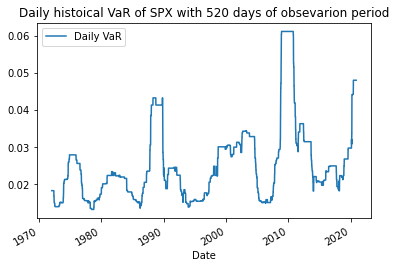

In [11]:
daily_historical_var.plot(title='Daily histoical VaR of SPX with 520 days of obsevarion period')

##### Parametric VaR
$$
VaR_{Parametric}=\mu-z\sigma
$$

In [12]:
from scipy.stats import norm
-(spx_ret.mean()+norm.ppf(.01)*spx_ret.std(ddof=0))

0.024867867892732504

In [13]:
def parametric_var(ret):
    return -(ret.mean()+norm.ppf(0.01)*ret.std(ddof=1))

In [14]:
pd.DataFrame({'VaR':spx_ret.rolling(520).apply(parametric_var).dropna().iloc[:-1]}, index=spx_ret.index[520:]).head()

,VaR
Date,
1972-01-21,0.018493
1972-01-24,0.018518
1972-01-25,0.018510
1972-01-26,0.018516
1972-01-27,0.018514


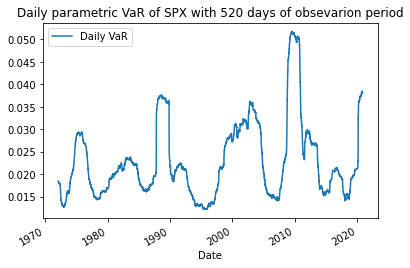

In [15]:
period = 520
parametric_var = []
for i in range(spx_ret.shape[0]-520):
    x = spx_ret.iloc[i:i+period]
    parametric_var.append(-(x.mean()+norm.ppf(.01)*x.std(ddof=1)))

daily_parametric_var = pd.DataFrame({'Daily VaR':parametric_var}, index=spx_ret.index[520:])
daily_parametric_var.plot(title='Daily parametric VaR of SPX with 520 days of obsevarion period')

##### Monte Carlo simulated VaR

In [16]:
n_sims = 10000
sim_returns = np.random.normal(spx_ret.mean(), spx_ret.std(), n_sims)
np.percentile(sim_returns, 1)

-0.02512197414347348

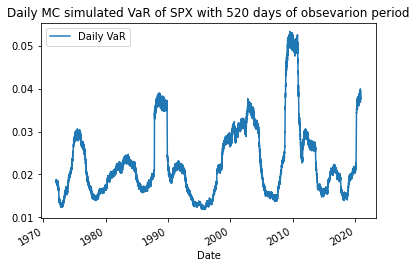

In [17]:
period = 520
MC_simulated_var = []
for i in range(spx_ret.shape[0]-520):
    x = spx_ret.iloc[i:i+period]
    MC_simulated_var.append(-(np.percentile(np.random.normal(x.mean(), x.std(), n_sims), 1)))

daily_MC_simulated_var = pd.DataFrame({'Daily VaR':MC_simulated_var}, index=spx_ret.index[520:])
daily_MC_simulated_var.plot(title='Daily MC simulated VaR of SPX with 520 days of obsevarion period')

In [18]:
np.percentile(np.random.gumbel(spx_ret.mean(), spx_ret.std(), n_sims),1)

-0.016305698688906082

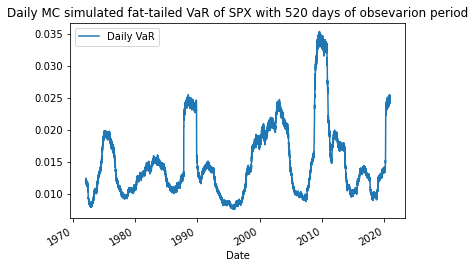

In [19]:
period = 520
MC_simulated_fattailed_var = []
for i in range(spx_ret.shape[0]-520):
    x = spx_ret.iloc[i:i+period]
    MC_simulated_fattailed_var.append(-(np.percentile(np.random.gumbel(x.mean(), x.std(), n_sims),1)))

daily_MC_simulated_fattailed_var = pd.DataFrame({'Daily VaR':MC_simulated_fattailed_var}, index=spx_ret.index[520:])
daily_MC_simulated_fattailed_var.plot(title='Daily MC simulated fat-tailed VaR of SPX with 520 days of obsevarion period')

In [20]:
VaR = pd.DataFrame()

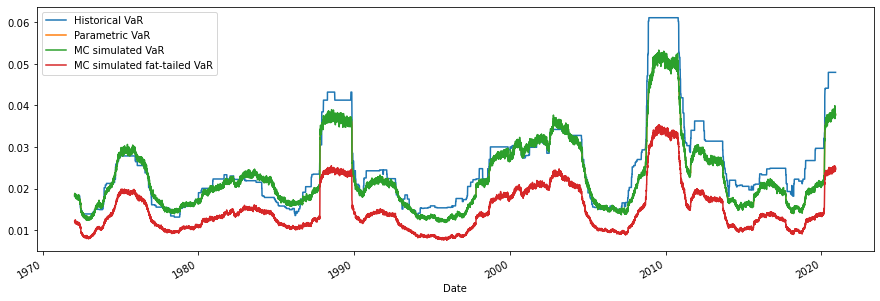

In [21]:
VaR['Historical VaR'] = daily_historical_var['Daily VaR']
VaR['Parametric VaR'] = daily_parametric_var['Daily VaR']
VaR['MC simulated VaR'] = daily_MC_simulated_var['Daily VaR']
VaR['MC simulated fat-tailed VaR'] = daily_MC_simulated_fattailed_var['Daily VaR']
VaR.plot(figsize=(15,5))

In [22]:
back_testing = VaR.iloc[:-1]
back_testing.head()
back_testing['SPX_ret'] = spx_ret.iloc[520:-1].values
back_testing['Overshoot_historical_VaR'] = [1 if -back_testing.loc[i, 'Historical VaR']>back_testing.loc[i, 'SPX_ret'] else 0 for i in back_testing.index]
back_testing['Overshoot_parametric_VaR'] = [1 if -back_testing.loc[i, 'Parametric VaR']>back_testing.loc[i, 'SPX_ret'] else 0 for i in back_testing.index]
back_testing['Overshoot_MC_simulated_VaR'] = [1 if -back_testing.loc[i, 'MC simulated VaR']>back_testing.loc[i, 'SPX_ret'] else 0 for i in back_testing.index]
back_testing['Overshoot_MC_simulated_fattailed_VaR'] = [1 if -back_testing.loc[i, 'MC simulated fat-tailed VaR']>back_testing.loc[i, 'SPX_ret'] else 0 for i in back_testing.index]
back_testing.tail()

,Historical VaR,Parametric VaR,MC simulated VaR,MC simulated fat-tailed VaR,SPX_ret,Overshoot_historical_VaR,Overshoot_parametric_VaR,Overshoot_MC_simulated_VaR,Overshoot_MC_simulated_fattailed_VaR
Date,,,,,,,,,
2020-11-19,0.047974,0.038016,0.038032,0.024828,0.003946,0,0,0,0
2020-11-20,0.047974,0.037932,0.037710,0.024148,-0.006793,0,0,0,0
2020-11-23,0.047974,0.037933,0.037817,0.024390,0.005636,0,0,0,0
2020-11-24,0.047974,0.037926,0.037908,0.025180,0.016162,0,0,0,0
2020-11-25,0.047974,0.037934,0.038000,0.024575,-0.001584,0,0,0,0


In [23]:
back_testing['Overshoot_historical_VaR']['2020'].sum()

11

In [24]:
back_testing['Overshoot_parametric_VaR'].sum()

272

In [25]:
back_testing['Overshoot_MC_simulated_VaR'].sum()

269

In [26]:
back_testing['Overshoot_MC_simulated_fattailed_VaR']['2020'].sum()

25

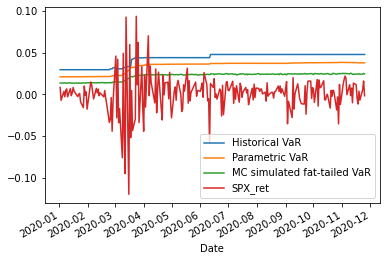

In [27]:
back_testing[['Historical VaR','Parametric VaR', 'MC simulated fat-tailed VaR', 'SPX_ret']]['2020'].plot()

##### CVaR

In [28]:
beyond_var = spx_ret <= np.percentile(spx_ret, 1)
(-spx_ret[beyond_var].mean())*100

4.325822612796965

In [29]:
def cvar(ret):
    beyond_var = ret <= np.percentile(ret, 1)
    return (-ret[beyond_var].mean())*100

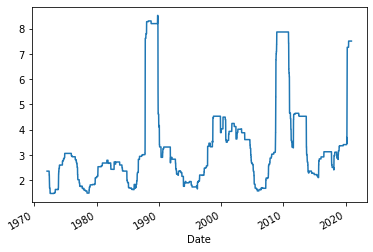

In [30]:
spx_ret.rolling(520).apply(cvar).plot()

In [31]:
stocks = ['RDSB.L','VOD.L','EXPN.L','RDSA.L','RTO.L','SSE.L','RMV.L','SPX.L','RB.L','BATS.L','SDR.L','PRU.L','SMIN.L','GVC.L','CPG.L','TSCO.L','SLA.L','STJ.L','AHT.L','ABF.L','BA.L','PSN.L','WTB.L','ANTO.L','RR.L']
prices = yf.download(stocks, start='2010-01-01', end='2020-11-30', progress=False)['Adj Close']
returns = prices.pct_change().dropna()
returns.head()

,ABF.L,AHT.L,ANTO.L,BA.L,BATS.L,CPG.L,EXPN.L,GVC.L,PRU.L,PSN.L,...,RTO.L,SDR.L,SLA.L,SMIN.L,SPX.L,SSE.L,STJ.L,TSCO.L,VOD.L,WTB.L
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.001217,0.014501,-0.005848,0.016344,-0.005905,-0.002618,-0.015360,0.000000,0.003125,0.003682,...,-0.006024,-0.008142,0.022660,-0.028999,0.023700,0.006019,0.031224,-0.018557,-0.001399,-0.001428
2010-01-06,-0.001218,-0.005360,0.017647,0.012265,0.005940,0.014657,-0.006568,0.007059,0.005452,0.012085,...,-0.004329,-0.022388,-0.002769,-0.015414,-0.002401,0.005128,-0.008050,-0.019979,-0.004189,-0.002146
2010-01-07,0.022561,0.016168,-0.014451,0.000269,0.006152,-0.015739,-0.006611,0.004673,-0.026336,0.066098,...,0.000869,0.010687,-0.025462,-0.019570,-0.011997,-0.014456,-0.020476,-0.000121,-0.025966,0.000717
2010-01-08,0.013715,0.050678,0.000978,-0.008076,-0.004647,0.008104,-0.003328,0.030233,0.015911,-0.017400,...,-0.000869,0.008308,0.016150,0.008982,0.051015,0.010354,0.009859,0.009588,-0.012970,0.010745
2010-01-11,0.004118,0.003926,-0.003907,-0.002985,-0.006143,0.011300,0.002504,0.000000,-0.018794,-0.016690,...,0.019131,-0.011985,-0.013089,0.009891,-0.001545,0.003416,0.054688,0.004568,0.006203,-0.005670


##### Sample covariance

In [32]:
sample_cov = returns.cov()
sample_cov

,ABF.L,AHT.L,ANTO.L,BA.L,BATS.L,CPG.L,EXPN.L,GVC.L,PRU.L,PSN.L,...,RTO.L,SDR.L,SLA.L,SMIN.L,SPX.L,SSE.L,STJ.L,TSCO.L,VOD.L,WTB.L
ABF.L,0.000260,0.000135,0.000097,0.000076,0.000077,0.000112,0.000084,0.000069,0.000145,0.000142,...,0.000062,0.000122,0.000133,0.000098,0.000070,0.000083,0.000125,0.000066,0.000084,0.000037
AHT.L,0.000135,0.000603,0.000268,0.000155,0.000101,0.000150,0.000167,0.000108,0.000262,0.000234,...,0.000161,0.000209,0.000234,0.000213,0.000167,0.000114,0.000220,0.000090,0.000118,0.002033
ANTO.L,0.000097,0.000268,0.000625,0.000133,0.000089,0.000107,0.000140,0.000070,0.000242,0.000158,...,0.000128,0.000207,0.000207,0.000190,0.000153,0.000098,0.000182,0.000111,0.000104,0.000209
BA.L,0.000076,0.000155,0.000133,0.000212,0.000070,0.000092,0.000095,0.000065,0.000145,0.000119,...,0.000085,0.000125,0.000130,0.000123,0.000086,0.000071,0.000117,0.000063,0.000080,0.000622
BATS.L,0.000077,0.000101,0.000089,0.000070,0.000191,0.000085,0.000085,0.000035,0.000099,0.000071,...,0.000065,0.000092,0.000092,0.000080,0.000065,0.000068,0.000086,0.000063,0.000082,-0.000837
CPG.L,0.000112,0.000150,0.000107,0.000092,0.000085,0.000229,0.000099,0.000067,0.000144,0.000121,...,0.000083,0.000110,0.000127,0.000120,0.000073,0.000077,0.000114,0.000058,0.000084,0.001508
EXPN.L,0.000084,0.000167,0.000140,0.000095,0.000085,0.000099,0.000216,0.000066,0.000144,0.000121,...,0.000115,0.000129,0.000135,0.000126,0.000107,0.000083,0.000126,0.000071,0.000084,0.001616
GVC.L,0.000069,0.000108,0.000070,0.000065,0.000035,0.000067,0.000066,0.000527,0.000129,0.000125,...,0.000057,0.000081,0.000112,0.000098,0.000046,0.000067,0.000090,0.000026,0.000047,-0.001066
PRU.L,0.000145,0.000262,0.000242,0.000145,0.000099,0.000144,0.000144,0.000129,0.000425,0.000220,...,0.000132,0.000229,0.000268,0.000194,0.000131,0.000120,0.000239,0.000103,0.000133,0.001158
PSN.L,0.000142,0.000234,0.000158,0.000119,0.000071,0.000121,0.000121,0.000125,0.000220,0.000489,...,0.000116,0.000192,0.000218,0.000155,0.000112,0.000119,0.000206,0.000092,0.000101,0.001574


In [33]:
symbols = ['BATS.L', 'PRU.L', 'TSCO.L', 'RDSB.L', 'RR.L']
sample_cov = sample_cov.loc[symbols,symbols]
sample_cov

,BATS.L,PRU.L,TSCO.L,RDSB.L,RR.L
BATS.L,0.000191,0.000099,0.000063,0.000091,0.000095
PRU.L,0.000099,0.000425,0.000103,0.000190,0.000246
TSCO.L,0.000063,0.000103,0.000252,0.000078,0.000082
RDSB.L,0.000091,0.000190,0.000078,0.000295,0.000193
RR.L,0.000095,0.000246,0.000082,0.000193,0.000840


##### Covariance matrix estimate: the Elton/Gruber Constant Correlation model

In [34]:
import statsmodels.stats.moment_helpers as mh
returns_here = returns[symbols]
correlation = returns_here.corr()
n = correlation.shape[0]
correlation_mean = (correlation.values.sum()-n)/(n*(n-1))
constant_cor = np.repeat(correlation_mean,n**2).reshape(n,n)
np.fill_diagonal(constant_cor, 1.)
vol = returns_here.std()
constant_cov = mh.corr2cov(constant_cor, vol)
constant_correlation_cov = pd.DataFrame(constant_cov, index=returns_here.columns, columns=returns_here.columns)
constant_correlation_cov

,BATS.L,PRU.L,TSCO.L,RDSB.L,RR.L
BATS.L,0.000191,0.000096,0.000074,0.000080,0.000135
PRU.L,0.000096,0.000425,0.000110,0.000119,0.000201
TSCO.L,0.000074,0.000110,0.000252,0.000092,0.000155
RDSB.L,0.000080,0.000119,0.000092,0.000295,0.000167
RR.L,0.000135,0.000201,0.000155,0.000167,0.000840


##### Statistical Shrinkage

In [35]:
shrinkage_parameter = 0.5
shrinkage_parameter*constant_correlation_cov + (1-shrinkage_parameter)*sample_cov

,BATS.L,PRU.L,TSCO.L,RDSB.L,RR.L
BATS.L,0.000191,0.000097,0.000068,0.000085,0.000115
PRU.L,0.000097,0.000425,0.000107,0.000154,0.000224
TSCO.L,0.000068,0.000107,0.000252,0.000085,0.000118
RDSB.L,0.000085,0.000154,0.000085,0.000295,0.000180
RR.L,0.000115,0.000224,0.000118,0.000180,0.000840


#### Liquidity

- Time to liquidate
- Cost to liquidate
- Liquidation size

Important inputs are volumes, bid-ask spreads, position size, participation rate, market elasticity, etc.